In [1]:
import numpy as np 
import astropy.constants as const
import scipy as sp

nmass = 255
na = 256

pi     = np.pi
au     = const.au.cgs.value
AU     = au
Mearth = const.M_earth.cgs.value
Msun   = const.M_sun.cgs.value
G      = const.G.cgs.value
amu    = const.u.cgs.value
kb     = const.k_B.cgs.value
Rgas   = const.R.cgs.value
yr     = 3.1558149504e7

sigma_mol = 2e-15
Gamma=1.4
Gamma1=1./Gamma
mmol=2.3
Rgasmu=Rgas/mmol
cp=Gamma*Rgasmu/(Gamma-1)
cv=cp/Gamma

import matplotlib.pyplot as plt


SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title and legend
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

rr=5

In [2]:
r=rr*AU
rhops = 3.5
Omega = np.sqrt(G*Msun/r**3)

Sigma_gas  = 1e3  * 0.2
max_a_bullet = 10 #cm St * (H * rho_gas) / rhops 
alpha = 1e-3
h  = 0.04
H  = h*r
Hp = 0.1 * H
Z = 0.004
cs = Omega * H 
Temperature = cs**2/cp/(Gamma-1)
    
Sigma_dust = Z * Sigma_gas 
rho_gas = Sigma_gas/sqrt(2*pi)/H

a_bullet=max_a_bullet    
St = a_bullet * rhops / (H*rho_gas)

rho_dust = Sigma_dust/sqrt(2*pi)/Hp

print("Sigma_gas =",Sigma_gas," g/cm^2")
print("rho_gas =",rho_gas," g/cm^3")
print("Sigma_dust =",Sigma_dust," g/cm^2")
print("rho_dust =",rho_dust," g/cm^3")
print("Scale Height=",H/AU," AU")
print("Particle Scale Height=",Hp/AU," AU")
print("Aspect Ratio=",H/r)
print("Omega=",Omega)
print("St=",St)
print("Temperature=",Temperature)

t_f = St/Omega

Sigma_gas = 200.0  g/cm^2
rho_gas = 2.6667644300998246e-11  g/cm^3
Sigma_dust = 0.8  g/cm^2
rho_dust = 1.06670577203993e-12  g/cm^3
Scale Height= 0.2  AU
Particle Scale Height= 0.02  AU
Aspect Ratio= 0.04
Omega= 1.780789935268516e-08
St= 0.438659948060425
Temperature= 56.09211497605384


In [3]:
def Sfunction(r,H):
    y = (r/2/H)**2
    I0 = sp.special.iv(0, y) 
    I1 = sp.special.iv(1, y) 
    S = np.exp(-y) * (I0 + I1)
    return S


def calc_mdot(Rhat,Hp,mp,t_f,rho_dust,rhill,ldeltav,lOmegaR):
    
    dv_tp = 0.
    if (ldeltav):
        dv_tp += deltav
    if (lOmegaR):
        dv_tp += Omega*rhill
            
    tp  = G*mp /dv_tp**3
    fac = exp(-chi * (t_f/tp)**gamma)

    Racc = Rhat * fac
        
    dv=0.
    if (ldeltav):
        dv += deltav
    if (lOmegaR):
        dv += Omega*Racc
     
    S = Sfunction(Racc,Hp)
    mdot = pi*  Racc**2 * rho_dust * dv * S
    
    return mdot


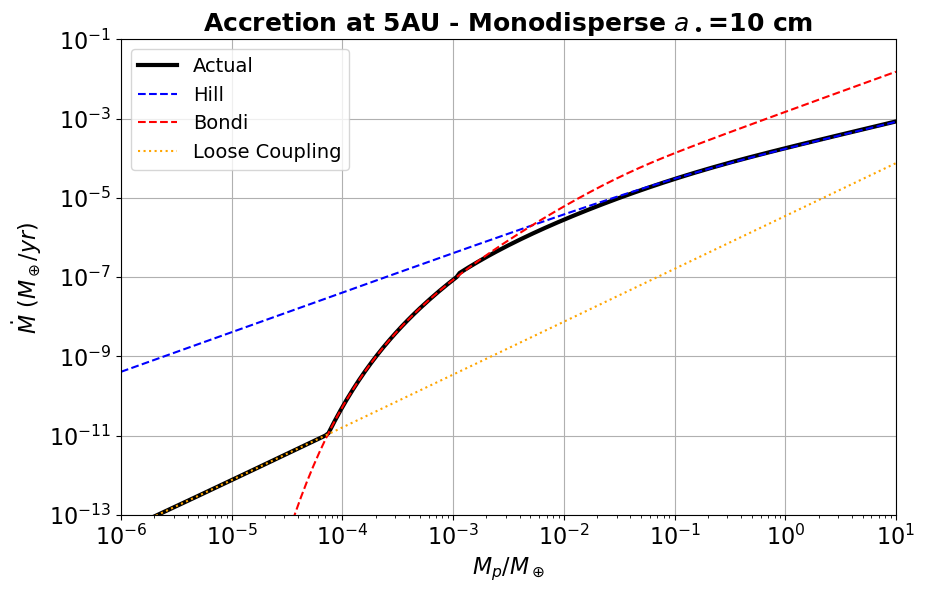

In [4]:
mp = np.logspace(-6,1,nmass) * Mearth

torb = 2*pi/Omega 
deltav = 30 * 1e2 #cm/s 

M_C = deltav**3 / G / Omega  # C for Chris

Mt = M_C / 8 / St

Mf = M_C /  8 * St 

chi = 0.4
gamma=0.65

R_Hill        = r*(1./3 * mp/Msun)**(1./3)
Rhat_Hill     = cbrt(St/0.1) * R_Hill 

R_Bondi       = G*mp / deltav**2
t_Bondi       = R_Bondi / deltav
Rhat_Bondi    = 2*sqrt(t_f/t_Bondi) * R_Bondi 

Rgeo          = cbrt(3*mp/(4*pi*rhops))
vesc          = sqrt(2*G*mp/Rgeo)  
Rhat_geo      = Rgeo*sqrt(1+vesc**2/deltav**2)

Rhat = np.zeros(nmass)
for i in range(nmass):
    if (mp[i]>=Mt):
        Rhat[i] = Rhat_Hill[i]
    else:
        Rhat[i] = Rhat_Bondi[i]  
    
mdot_pebble    = calc_mdot(Rhat      ,Hp,mp,t_f,rho_dust,R_Hill,True ,True) #lDeltav, lOmegaR              

mdot_Hill      = calc_mdot(Rhat_Hill ,Hp,mp,t_f,rho_dust,R_Hill,False,True) #lDeltav, lOmegaR               
mdot_Bondi     = calc_mdot(Rhat_Bondi,Hp,mp,t_f,rho_dust,R_Hill,True ,True) #lDeltav, lOmegaR               

Sgeo       = Sfunction(Rgeo,Hp)
mdot_focusing = np.zeros(nmass)
for i in range(nmass):
    Stk = deltav * t_f / Rgeo[i]
    if (Stk > 1): 
        mdot_focusing[i] = pi*Rhat_geo[i]**2 * rho_dust * deltav * Sgeo[i] 
    else:
        mdot_focusing[i] = 0.    

mdot=np.zeros(nmass)
for i in range(nmass):
    mdot[i]=max(mdot_pebble[i],mdot_focusing[i])

            
phi=1.618
plt.figure(figsize=(10,10/phi))
            
plot(mp/Mearth,mdot / Mearth * yr,color='black',label='Actual',linewidth=3)

plot(mp/Mearth,mdot_Hill / Mearth * yr,label='Hill',linestyle='--',color='blue')
plot(mp/Mearth,mdot_Bondi / Mearth * yr,label='Bondi',linestyle='--',color='red')

plot(mp/Mearth,mdot_focusing / Mearth * yr,label='Loose Coupling',linestyle=':',color='orange')

xscale('log')
yscale('log')

xlabel(r'$M_p / M_\oplus$')
ylabel(r'$\dot{M} \ (M_\oplus/yr)$')

title('Accretion at '+str(rr)+'AU - Monodisperse '+r'$a_\bullet$='+str(a_bullet)+' cm',fontweight="bold",size=18)

xlim([1e-6,1e1])
ylim([1e-13,1e-1])

grid()

legend()
 
mdot_mono = mdot     
